In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import os

In [2]:
# Seeds for Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Data Loading and Feature Engineering
try:
          df = pd.read_csv("ML-Dataset.csv")
except FileNotFoundError:
          print("Error: 'ML-Dataset.csv' not found. Please ensure the file is in the correct path.")
          exit()

In [5]:
TARGET_COLUMN = 'Profit'
y = df[TARGET_COLUMN]
y

0      542.95
1      448.71
2      625.54
3      410.59
4      489.58
        ...  
395    185.63
396    168.84
397    121.04
398    147.64
399     96.81
Name: Profit, Length: 400, dtype: float64

In [6]:
COLUMNS_TO_DROP = [
    'CustomerName', 'CustomerAddress', 'CustomerEmail', 'CustomerPhone',
    'EmployeeName', 'EmployeeEmail', 'EmployeePhone', 'EmployeeHireDate',
    'WarehouseAddress', 'WarehouseName', 'PostalCode',
    'ProductStandardCost', 'ProductListPrice'
]

X = df.drop(COLUMNS_TO_DROP + [TARGET_COLUMN], axis=1)
X

,RegionName,CountryName,State,City,EmployeeJobTitle,CategoryName,ProductName,ProductDescription,CustomerCreditLimit,Status,OrderDate,OrderItemQuantity,PerUnitPrice,TotalItemQuantity
0,South America,United States of America,Texas,Southlake,Public Accountant,CPU,Intel Xeon E5-2699 V3 (OEM/Tray),"Speed:2.3GHz,Cores:18,TDP:145W",5000,Shipped,17-Nov-16,132,469.99,122
1,South America,United States of America,Texas,Southlake,Accounting Manager,CPU,Intel Xeon E5-2697 V3,"Speed:2.6GHz,Cores:14",5000,Shipped,20-Feb-17,124,519.99,123
2,South America,United States of America,Texas,Southlake,Administration Assistant,CPU,Intel Xeon E5-2698 V3 (OEM/Tray),Speed:2.3GHz,1200,Canceled,03-Jan-17,92,800.74,123
3,South America,United States of America,Texas,Southlake,President,CPU,Intel Xeon E5-2697 V4,"Cores:18,TDP:145W",2400,Pending,15-Oct-17,128,849.99,124
4,South America,United States of America,Texas,Southlake,Administration Vice President,CPU,Intel Xeon E5-2685 V3 (OEM/Tray),"Speed:2.6GHz,Cores:12",1200,Shipped,09-Apr-17,106,109.99,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Asia,India,Maharashtra,Bombay,Stock Clerk,Video Card,MSI GTX 1080 TI LIGHTNING Z,Chipset:GeForce GTX 1080 Ti,4900,Shipped,27-Sep-17,32,725.99,107
396,Asia,India,Maharashtra,Bombay,Stock Manager,Video Card,Asus ROG-POSEIDON-GTX1080TI-P11G-GAMING,Chipset:GeForce GTX 1080 Ti,5000,Pending,16-Aug-16,66,798.26,118
397,Asia,India,Maharashtra,Bombay,Stock Manager,Video Card,MSI GTX 1080 TI LIGHTNING X,Chipset:GeForce GTX 1080 Ti,4000,Canceled,27-May-16,82,849.99,118
398,Asia,India,Maharashtra,Bombay,Stock Manager,Video Card,Zotac ZT-P10810A-10P,Chipset:GeForce GTX 1080 Ti,3000,Shipped,27-May-17,157,821.99,95


In [7]:
print(f"Original shape: {df.shape}")

Original shape: (400, 28)


In [8]:
# Feature Engineering (Temporal Data)
X['OrderDate'] = pd.to_datetime(X['OrderDate'], format='%d-%b-%y')
X['Order_Month'] = X['OrderDate'].dt.month
X['Order_Year'] = X['OrderDate'].dt.year
X['Order_Weekday'] = X['OrderDate'].dt.dayofweek
X = X.drop('OrderDate', axis=1)
X

,RegionName,CountryName,State,City,EmployeeJobTitle,CategoryName,ProductName,ProductDescription,CustomerCreditLimit,Status,OrderItemQuantity,PerUnitPrice,TotalItemQuantity,Order_Month,Order_Year,Order_Weekday
0,South America,United States of America,Texas,Southlake,Public Accountant,CPU,Intel Xeon E5-2699 V3 (OEM/Tray),"Speed:2.3GHz,Cores:18,TDP:145W",5000,Shipped,132,469.99,122,11,2016,3
1,South America,United States of America,Texas,Southlake,Accounting Manager,CPU,Intel Xeon E5-2697 V3,"Speed:2.6GHz,Cores:14",5000,Shipped,124,519.99,123,2,2017,0
2,South America,United States of America,Texas,Southlake,Administration Assistant,CPU,Intel Xeon E5-2698 V3 (OEM/Tray),Speed:2.3GHz,1200,Canceled,92,800.74,123,1,2017,1
3,South America,United States of America,Texas,Southlake,President,CPU,Intel Xeon E5-2697 V4,"Cores:18,TDP:145W",2400,Pending,128,849.99,124,10,2017,6
4,South America,United States of America,Texas,Southlake,Administration Vice President,CPU,Intel Xeon E5-2685 V3 (OEM/Tray),"Speed:2.6GHz,Cores:12",1200,Shipped,106,109.99,125,4,2017,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Asia,India,Maharashtra,Bombay,Stock Clerk,Video Card,MSI GTX 1080 TI LIGHTNING Z,Chipset:GeForce GTX 1080 Ti,4900,Shipped,32,725.99,107,9,2017,2
396,Asia,India,Maharashtra,Bombay,Stock Manager,Video Card,Asus ROG-POSEIDON-GTX1080TI-P11G-GAMING,Chipset:GeForce GTX 1080 Ti,5000,Pending,66,798.26,118,8,2016,1
397,Asia,India,Maharashtra,Bombay,Stock Manager,Video Card,MSI GTX 1080 TI LIGHTNING X,Chipset:GeForce GTX 1080 Ti,4000,Canceled,82,849.99,118,5,2016,4
398,Asia,India,Maharashtra,Bombay,Stock Manager,Video Card,Zotac ZT-P10810A-10P,Chipset:GeForce GTX 1080 Ti,3000,Shipped,157,821.99,95,5,2017,5


In [9]:
# Preprocessing using ColumnTransformer (SKLearn)
NUMERICAL_FEATURES = ['CustomerCreditLimit', 'OrderItemQuantity', 'TotalItemQuantity', 'Order_Month', 'Order_Year', 'Order_Weekday']
CATEGORICAL_FEATURES = X.select_dtypes(include=['object']).columns.tolist()

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
          transformers=[
                    ('num', StandardScaler(), NUMERICAL_FEATURES),
                    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
          ],
          remainder = 'passthrough'
)

print("Preprocessing data...")
X_train_np = preprocessor.fit_transform(X_train_raw)
X_test_np = preprocessor.transform(X_test_raw)

Preprocessing data...


In [10]:
# Extracting 20% validation split from training data for callbacks
X_train_data_np, X_val_np, y_train_data_np, y_val_np = train_test_split(
          X_train_np, y_train.values, test_size=0.2, random_state=42
)

In [11]:

input_dim = X_train_np.shape[1]
print(f"Processed feature count (Input Dimension): {input_dim}")

Processed feature count (Input Dimension): 498


In [12]:
X_train_np

array([[ 1.93470588e-01,  1.20495243e+00, -2.06006865e-02, ...,
         1.00000000e+00,  0.00000000e+00,  8.49990000e+02],
       [-8.99981044e-01, -2.74234458e-01, -6.56500237e-02, ...,
         0.00000000e+00,  0.00000000e+00,  8.99990000e+02],
       [-5.78377623e-01, -3.34609433e-01,  1.07559985e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.68900000e+01],
       ...,
       [-9.64301728e-01,  1.11438997e+00,  7.90287383e-01, ...,
         0.00000000e+00,  0.00000000e+00,  1.89999000e+03],
       [ 7.08036062e-01, -3.34609433e-01,  1.31586298e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.46996000e+03],
       [ 1.93470588e-01, -7.57234259e-01, -1.77752484e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.46996000e+03]],
      shape=(320, 498))

In [13]:
y_train

3      410.59
18     526.88
202    118.71
250    346.35
274     14.81
        ...  
71     519.86
106    218.37
270      0.00
348      0.00
102    226.48
Name: Profit, Length: 320, dtype: float64

In [14]:
y_train.values

array([4.1059e+02, 5.2688e+02, 1.1871e+02, 3.4635e+02, 1.4810e+01,
       6.3760e+01, 1.4870e+01, 2.0000e+02, 1.6553e+02, 1.1808e+02,
       5.8060e+01, 2.2038e+02, 2.2075e+02, 7.6520e+01, 9.3100e+01,
       3.5000e+02, 4.9720e+01, 4.8692e+02, 1.6900e+01, 5.1551e+02,
       1.7350e+01, 2.2496e+02, 2.3275e+02, 1.6809e+02, 1.2873e+02,
       4.8964e+02, 4.7506e+02, 1.0449e+02, 0.0000e+00, 0.0000e+00,
       2.9647e+02, 4.6196e+02, 2.0000e+02, 4.9157e+02, 2.6500e+02,
       1.3003e+02, 4.1290e+02, 1.3940e+01, 1.9620e+03, 1.7600e+00,
       7.1340e+01, 9.3400e+01, 1.9304e+02, 0.0000e+00, 2.2481e+02,
       1.3006e+02, 0.0000e+00, 5.2688e+02, 1.1454e+02, 2.4380e+01,
       2.5000e+02, 9.1150e+01, 0.0000e+00, 1.6421e+02, 1.8492e+02,
       5.8480e+01, 4.9720e+01, 0.0000e+00, 3.5290e+01, 3.2000e+02,
       1.2720e+02, 1.9496e+02, 2.2500e+02, 1.2478e+02, 1.0218e+02,
       3.8940e+01, 1.1904e+02, 1.7989e+02, 7.8590e+01, 8.7000e+01,
       2.7550e+02, 4.7506e+02, 2.9200e+00, 1.1877e+02, 2.2839e

In [15]:
y_train_data_np

array([6.6980e+01, 0.0000e+00, 2.5982e+02, 9.6810e+01, 1.0547e+02,
       9.3300e+00, 1.4010e+02, 1.0792e+02, 0.0000e+00, 7.4890e+01,
       1.4360e+01, 4.6196e+02, 0.0000e+00, 2.3129e+02, 5.7260e+01,
       4.3360e+01, 1.3886e+02, 1.8670e+01, 3.2000e+02, 4.8327e+02,
       1.4870e+01, 9.1000e+01, 2.9647e+02, 2.3275e+02, 4.2990e+01,
       1.5068e+02, 4.9720e+01, 4.6196e+02, 3.0954e+02, 5.0020e+01,
       8.9630e+01, 6.2430e+01, 1.7600e+00, 0.0000e+00, 2.3940e+02,
       3.1886e+02, 5.1986e+02, 0.0000e+00, 5.0538e+02, 1.1904e+02,
       9.5480e+01, 1.6900e+01, 1.4267e+02, 2.8208e+02, 5.1551e+02,
       2.9835e+02, 2.6850e+02, 1.4764e+02, 1.9200e+02, 1.2050e+01,
       2.9200e+00, 1.0500e+02, 3.5000e+02, 1.2546e+02, 5.8060e+01,
       1.2143e+02, 8.7000e+01, 1.8960e+01, 3.3000e+02, 7.8590e+01,
       9.6630e+01, 1.3940e+01, 1.9596e+02, 4.9720e+01, 6.6520e+01,
       1.7989e+02, 8.4850e+01, 0.0000e+00, 1.8048e+02, 4.4697e+02,
       5.8060e+01, 1.0346e+02, 1.8078e+02, 2.3940e+02, 3.5290e

In [16]:
# PyTorch Data Conversion

# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_data_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_data_np, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

In [17]:
# Create TensorDatasets and DataLoaders
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
X_train_tensor

tensor([[-1.0286e+00, -1.0289e+00,  8.4514e-02,  ...,  0.0000e+00,
          1.0000e+00,  1.1000e+03],
        [-9.6430e-01,  1.1144e+00,  7.9029e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.9000e+03],
        [-6.4270e-01,  6.9177e-01,  7.3022e-01,  ...,  0.0000e+00,
          0.0000e+00,  1.0740e+03],
        ...,
        [-1.2813e-01,  1.3559e+00,  7.3022e-01,  ...,  0.0000e+00,
          1.0000e+00,  5.6489e+02],
        [ 1.0296e+00,  1.8691e+00,  7.7527e-01,  ...,  1.0000e+00,
          0.0000e+00,  8.4999e+02],
        [ 1.8658e+00, -5.4592e-01, -1.6123e+00,  ...,  0.0000e+00,
          1.0000e+00,  1.4988e+02]])

In [19]:
# Validation data is kept as tensors for full batch validation
X_val_tensor = X_val_tensor.to(device) 
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

In [20]:
# PyTorch Model Classes (Equivalent to Keras)
L2_REG = 0.001

class SimpleDNN(nn.Module):
          """A baseline, shallow neural network."""
          def __init__(self, input_dim):
                    super(SimpleDNN, self).__init__()
                    self.name = "Simple_DNN_3_Layers_L2"
                    self.layers = nn.Sequential(
                              nn.Linear(input_dim, 64),
                              nn.ReLU(),
                              nn.Linear(64, 32),
                              nn.ReLU(),
                              nn.Linear(32, 1)
                    )
          
          def forward(self, x):
                    return self.layers(x)

class DeepDNN(nn.Module):
          """A deeper network with increased capacity (6 layers)"""
          def __init__(self, input_dim):
                    super(DeepDNN, self).__init__()
                    self.name = "Deep_DNN_6_Layers_L2"
                    self.layers = nn.Sequential(
                              nn.Linear(input_dim, 256),
                              nn.ReLU(),
                              nn.Linear(256, 128),
                              nn.ReLU(),
                              nn.Linear(128, 64),
                              nn.ReLU(),
                              nn.Linear(64, 64),
                              nn.ReLU(),
                              nn.Linear(64, 32),
                              nn.ReLU(),
                              nn.Linear(32, 1)
                    )
                    
          def forward(self, x):
                    return self.layers(x)

class RegularizedDNN(nn.Module):
          """Deep network with Dropout and BatchNormalization."""
          def __init__(self, input_dim):
                    super(RegularizedDNN, self).__init__()
                    self.name = "Regularized_DNN_Robust"
                    self.layers = nn.Sequential(
                              nn.Linear(input_dim, 256),
                              nn.ReLU(),
                              nn.BatchNorm1d(256),
                              nn.Dropout(0.3),
                              
                              nn.Linear(256, 128),
                              nn.ReLU(),
                              nn.BatchNorm1d(128),
                              nn.Dropout(0.3),
                              
                              nn.Linear(128, 64),
                              nn.ReLU(),
                              
                              nn.Linear(64, 1)
                    )
          
          def forward(self, x):
                    return self.layers(x)
          
class WideNetwork(nn.Module):
          """A very wide network with fewer layers."""
          def __init__(self, input_dim):
                    super(WideNetwork, self).__init__()
                    self.name = "Wide_Network_L2"
                    self.layers = nn.Sequential(
                              nn.Linear(input_dim, 512),
                              nn.ReLU(),
                              nn.Dropout(0.2),
                              nn.Linear(512, 1)
                    )
          
          def forward(self, x):
                    return self.layers(x)

In [21]:
# PyTorch Callbacks
class EarlyStoppingPytorch:
          """Early stops the training if validation losss doesn't imporve after a given patience. Decreases Overfitting."""
          def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
                    self.patience = patience
                    self.verbose = verbose
                    self.counter = 0
                    self.best_score = None
                    self.early_stop = False
                    self.val_loss_min = np.inf
                    self.delta = delta
                    self.path = path
                    
          def __call__(self, val_loss, model):
                    score = -val_loss
                    
                    if self.best_score is None:
                              self.best_score = score
                              self.save_checkpoint(val_loss, model)
                    elif score < self.best_score + self.delta:
                              self.counter += 1
                              if self.verbose:
                                        print(f"EarlyStopping counter: {self.counter} of {self.patience}")
                              if self.counter >= self.patience:
                                        self.early_stop = True
                    else:
                              self.best_score = score
                              self.save_checkpoint(val_loss, model)
                              self.counter = 0
                              
          def save_checkpoint(self, val_loss, model):
                    """Saves model when validation loss decreases."""
                    if self.verbose:
                              print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
                    torch.save(model.state_dict(), self.path)
                    self.val_loss_min = val_loss

In [22]:
# Training and Evaluation Function
def train_and_evaluate_pytorch_model(model, train_loader, X_val, y_val, X_test, y_test, epochs=300, patience=20, lr_scheduler_config=None):
          """
          Handles the PyTorch training loop, including callbacks.
          L2 regularization is applied via the optimizer's weight_decay parameter.
          """
          model.to(device)
          
          # Use SmoothL1Loss (Huber Loss equivalent)
          criterion = nn.SmoothL1Loss().to(device)
          
          # RMSprop for Regularized_DNN_Robust, Adam otherwise
          if model.name == 'Regularized_DNN_Robust':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=L2_REG)
          else:
                    # L2 Regularization (weight_decay) is applied here
                    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=L2_REG)
          
          # Initialize Callbacks
          early_stopper = EarlyStoppingPytorch(patience=patience, verbose=False, path=f'{model.name}_checkpoint.pt')
          
          # ReduceLROnPlateau
          scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer,
                    mode='min',
                    factor=0.5,
                    patience=5,
                    min_lr=0.0001
          )
          
          print(f"\nTraining {model.name}...")
          
          # Training Loop
          for epoch in range(1, epochs + 1):
                    model.train()
                    total_loss = 0
                    
                    for batch_x, batch_y in train_loader:
                              batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                              
                              optimizer.zero_grad()
                              outputs = model(batch_x)
                              loss = criterion(outputs, batch_y)
                              loss.backward()
                              optimizer.step()
                              total_loss += loss.item()
                              
                    # Validation Step
                    model.eval()
                    with torch.no_grad():
                              val_outputs = model(X_val)
                              val_loss = criterion(val_outputs, y_val).item()
                              
                    # Apply Callbacks
                    scheduler.step(val_loss) # ReduceLROnPlateau
                    early_stopper(val_loss, model)
                    
                    if epoch % 50 == 0:
                              print(f"Epoch {epoch:03d}/{epochs} - Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
                              
                    if early_stopper.early_stop:
                              print(f"Epoch {epoch:03d}/{epochs} - Early stopping triggered.")
                              break
                    
          # Load best weights
          model.load_state_dict(torch.load(early_stopper.path))
          model.eval()
          
          # Final Evaluation on Test Set
          with torch.no_grad():
                    y_pred_tensor = model(X_test)
                    y_pred = y_pred_tensor.cpu().numpy().flatten()
                    
          # Calculate Metrics
          mae = mean_absolute_error(y_test, y_pred)
          mse = mean_squared_error(y_test, y_pred)
          r2 = r2_score(y_test, y_pred)
          
          # Clean up checkpoint file
          if os.path.exists(early_stopper.path):
                    os.remove(early_stopper.path)
                    
          return {'MAE': mae, 'MSE': mse, 'R2': r2}          

In [23]:
# Main Execution
# Dictionary of model builders
model_builders = [
          SimpleDNN,
          DeepDNN,
          RegularizedDNN,
          WideNetwork
]

results = {}
EPOCHS = 300
PATIENCE = 20

print("\n" + "="*80)
print("STARTING PYTORCH MODEL TRAINING AND COMPARISON")
print("="*80)

for builder in model_builders:
          model = builder(input_dim)
          model_name = model.name
          
          model_results = train_and_evaluate_pytorch_model(
                    model,
                    train_loader,
                    X_val_tensor,
                    y_val_tensor,
                    X_test_tensor,
                    y_test,
                    epochs=EPOCHS,
                    patience=PATIENCE
          )
          
          results[model_name] = model_results


STARTING PYTORCH MODEL TRAINING AND COMPARISON

Training Simple_DNN_3_Layers_L2...
Epoch 050/300 - Loss: 159.7595, Val Loss: 140.2757
Epoch 100/300 - Loss: 158.4745, Val Loss: 139.1401
Epoch 150/300 - Loss: 155.0272, Val Loss: 136.0134
Epoch 200/300 - Loss: 145.6190, Val Loss: 127.5271
Epoch 250/300 - Loss: 129.5608, Val Loss: 112.5780
Epoch 300/300 - Loss: 109.1416, Val Loss: 98.4563

Training Deep_DNN_6_Layers_L2...
Epoch 050/300 - Loss: 156.8631, Val Loss: 137.4582
Epoch 100/300 - Loss: 78.1586, Val Loss: 84.0568
Epoch 150/300 - Loss: 66.6630, Val Loss: 78.7321
Epoch 200/300 - Loss: 61.6882, Val Loss: 76.8095
Epoch 250/300 - Loss: 56.5261, Val Loss: 76.2290
Epoch 300/300 - Loss: 53.5319, Val Loss: 75.3586

Training Regularized_DNN_Robust...
Epoch 050/300 - Loss: 97.9666, Val Loss: 88.7782
Epoch 070/300 - Early stopping triggered.

Training Wide_Network_L2...
Epoch 050/300 - Loss: 146.1353, Val Loss: 127.9429
Epoch 100/300 - Loss: 104.8659, Val Loss: 94.1337
Epoch 150/300 - Loss: 81

In [25]:
# Display Results
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.sort_values(by='R2', ascending=False)

print("\n" + "="*80)
print("                      PYTORCH MODEL COMPARISON")
print("="*80)
print(metrics_df.to_markdown(floatfmt=".3f"))
print("="*80)


                      PYTORCH MODEL COMPARISON
|                        |     MAE |       MSE |     R2 |
|:-----------------------|--------:|----------:|-------:|
| Deep_DNN_6_Layers_L2   | 101.749 | 41127.092 |  0.130 |
| Wide_Network_L2        | 105.075 | 41634.660 |  0.120 |
| Regularized_DNN_Robust | 106.968 | 43557.861 |  0.079 |
| Simple_DNN_3_Layers_L2 | 128.954 | 53063.318 | -0.122 |


C:\Users\Rayquaza\AppData\Local\Temp\ipykernel_4676\4112019543.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='R2', data=plot_df.sort_values(by='R2', ascending=False), palette='viridis')
C:\Users\Rayquaza\AppData\Local\Temp\ipykernel_4676\4112019543.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='MAE', data=plot_df.sort_values(by='MAE', ascending=True), palette='plasma')


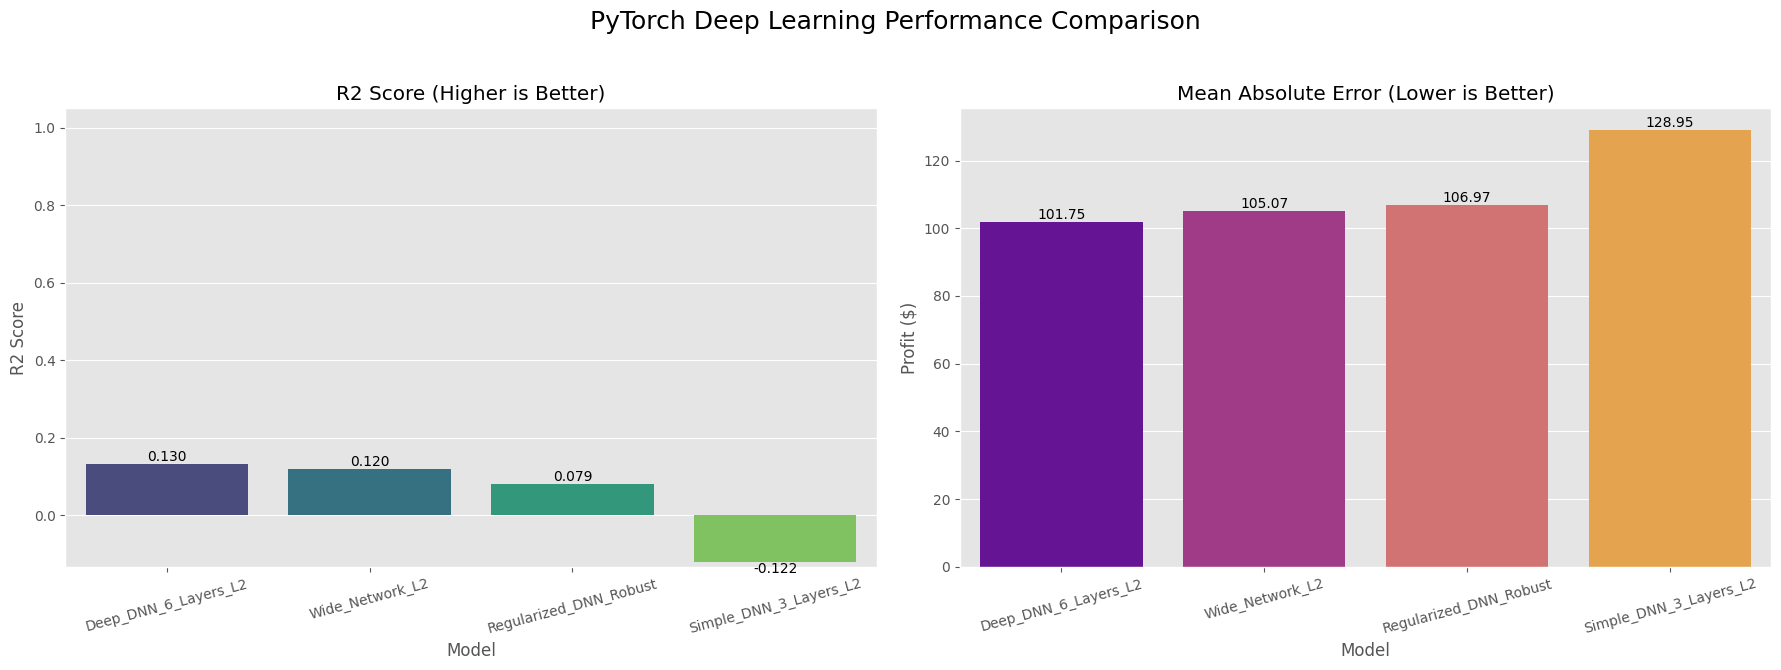

In [26]:
# Visualization

metrics_to_plot = ['R2', 'MAE']
plot_df = metrics_df[metrics_to_plot].reset_index().rename(columns={'index': 'Model'})

plt.style.use('ggplot')
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('PyTorch Deep Learning Performance Comparison', fontsize=18)

# Plot R2 Score
sns.barplot(ax=axes[0], x='Model', y='R2', data=plot_df.sort_values(by='R2', ascending=False), palette='viridis')
axes[0].set_title('R2 Score (Higher is Better)')
axes[0].set_ylim(min(plot_df['R2'].min(), 0) * 1.1, max(plot_df['R2'].max(), 1.0) * 1.05)
axes[0].set_ylabel('R2 Score')
axes[0].tick_params(axis='x', rotation=15)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f')

# Plot MAE (Mean Absolute Error)
sns.barplot(ax=axes[1], x='Model', y='MAE', data=plot_df.sort_values(by='MAE', ascending=True), palette='plasma')
axes[1].set_title('Mean Absolute Error (Lower is Better)')
axes[1].set_ylabel('Profit ($)')
axes[1].tick_params(axis='x', rotation=15)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [27]:
print("\n--- Summary ---")
best_model = metrics_df.index[0]
best_r2 = metrics_df.iloc[0]['R2']
best_mae = metrics_df.iloc[0]['MAE']

print(f"The best performing DL architecture is {best_model}")
print(f"R2: {best_r2}, MAE: {best_mae}")


--- Summary ---
The best performing DL architecture is Deep_DNN_6_Layers_L2
R2: 0.1304329900872302, MAE: 101.7492907369137
